In [ ]:
# Assignment 4 - Survival Analysis:  

In [31]:
# Imported the following packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                                                               # For data visualization (plotting graphs). 
from lifelines import KaplanMeierFitter                                                       # For the Kaplan-Meier (KM) analysis. 
import itertools                                                                              # Used in the KM loop for the group iterations. 
from lifelines.statistics import logrank_test                                                 # Used in KM analysis to conduct the log-rank tests. 
from lifelines import CoxPHFitter                                                             # For the Cox Proportional Hazards (CPH) regression (standard one). 
from sksurv.linear_model import CoxnetSurvivalAnalysis                                        # For the L1 linearized CPH regression.  
from sklearn.model_selection import train_test_split                                          # Used for both RSF (Random Survival Forests) and CPH models. 
from sksurv.metrics import concordance_index_censored                                         # For the L1 linearized CPH regression.
from sksurv.ensemble import RandomSurvivalForest                                              # Used in the RSF model. 
from sksurv.preprocessing import OneHotEncoder                                                # Used in the RSF model. 
from sklearn.inspection import permutation_importance                                         # Used in the RSF model. 

In [ ]:
# Part 2 - Dataset for Analysis:

In [ ]:
# 2.1. Imported the RADCURE_Clinical dataset: 

%pip install openpyxl

rad_clin_data = pd.read_excel("C:/Users/Zahin/Desktop/Semester 2/Machine Learning and AI/Assignment 4/RADCURE_Clinical_v04_20241219.xlsx")
# rad_clin_data.head()          
rad_clin_data.info()
rad_clin_data.describe()

Note: you may need to restart the kernel to use updated packages.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346 entries, 0 to 3345
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   patient_id         3346 non-null   object        
 1   Age                3346 non-null   float64       
 2   Sex                3346 non-null   object        
 3   ECOG PS            3345 non-null   object        
 4   Smoking PY         3341 non-null   object        
 5   Smoking Status     3346 non-null   object        
 6   Ds Site            3346 non-null   object        
 7   Subsite            2972 non-null   object        
 8   T                  3334 non-null   object        
 9   N                  3333 non-null   object        
 10  M                  3332 non-null   object        
 11  Stage              3319 non-null   object        
 12  Path               3346 non-null   object        
 1

,Age,RT Start,Dose,Fx,Last FU,Length FU,Date of Death,Date Local,Date Regional,Date Distant,Date 2nd Ca,ContrastEnhanced
count,3346.000000,3346,3346.000000,3346.000000,3346,3346.000000,1058,380,189,413,439,3346.000000
mean,62.300418,2005-05-11 00:38:43.968918016,66.658240,33.024806,2009-05-09 01:23:03.622235648,4.136047,2006-06-11 08:31:45.482041600,2006-01-25 13:34:44.210526336,2006-01-08 02:55:14.285714304,2006-08-04 02:05:31.234866944,2006-06-29 06:27:03.690205056,0.601614
min,15.600000,1999-02-07 00:00:00,50.000000,20.000000,1999-06-22 00:00:00,0.156164,1999-06-22 00:00:00,1999-05-18 00:00:00,1999-05-18 00:00:00,1999-08-30 00:00:00,1999-05-26 00:00:00,0.000000
25%,54.500000,2002-07-23 06:00:00,64.000000,35.000000,2007-06-25 00:00:00,1.879452,2004-02-14 12:00:00,2003-01-28 06:00:00,2003-01-21 00:00:00,2004-01-12 00:00:00,2003-12-07 00:00:00,0.000000
50%,62.100000,2005-06-18 00:00:00,70.000000,35.000000,2010-06-22 00:00:00,3.663014,2006-09-14 12:00:00,2006-01-05 12:00:00,2006-05-10 00:00:00,2006-07-02 00:00:00,2006-09-11 00:00:00,1.000000
75%,70.300000,2008-04-19 18:00:00,70.000000,35.000000,2011-12-04 18:00:00,5.791781,2008-10-28 00:00:00,2009-01-02 12:00:00,2009-01-03 00:00:00,2009-08-05 00:00:00,2009-04-09 00:00:00,1.000000
max,90.000000,2011-03-21 00:00:00,74.000000,60.000000,2012-06-30 00:00:00,12.909589,2012-04-07 00:00:00,2012-04-30 00:00:00,2012-04-02 00:00:00,2012-06-19 00:00:00,2012-06-13 00:00:00,1.000000
std,11.645892,NaN,5.754948,5.206841,NaN,2.734757,NaN,NaN,NaN,NaN,NaN,0.489639


In [34]:
# 2.2. Data Preprocessing: 

print(rad_clin_data.columns)                                    # This step was performed to check for column names in the dataset. 

num_missing = rad_clin_data.isnull().sum()                      # This step was performed to assess the percentage of missing values in each column of the dataset. 
percent_missing = (num_missing / len(rad_clin_data)) * 100
missing_values = pd.DataFrame({
	"Number of missing values": num_missing,
	"Percentage": percent_missing
})
missing_values = missing_values[missing_values["Number of missing values"] > 0]
print(missing_values.sort_values(by = "Percentage", ascending = False))

# To confirm if there are missing values in other numeric columns: 

print(rad_clin_data[['Age', 'Dose', 'Fx', 'Length FU', 'RADCURE-challenge', 
                     'ContrastEnhanced', 'Last FU', 'RT Start']].isnull().sum())        # There are no missing values in these numeric columns.


# To confirm if there are missing values in other categorical columns: 

print(rad_clin_data[['patient_id', 'Sex', 'Smoking Status', 'Ds Site', 
					 'Stage', 'Path', 'Tx Modality', 'Chemo', 'Status',
					 'RADCURE-challenge', 'ContrastEnhanced']].isnull().sum())          # There are no missing values in these categorical columns.


# Since the following columns had > 75% of missing values, I decided to drop them since they will not be used for further analysis and the missing values 
# will most likely cause result biases: 

cols_to_drop = ['Date Regional', 'Regional', 'Local', 'Date Local', 'Date Distant', 'Distant', 'Date 2nd Ca', '2nd Ca']
rad_clin_data = rad_clin_data.drop(columns=cols_to_drop, errors='ignore')
print(rad_clin_data.columns)

# To handle missing data in the "Smoking PY" numeric column, dropna was implemented (since its percentage of missing values is < 1%): 

numeric_cols_cleaned = rad_clin_data.dropna(subset=['Smoking PY'])
#print(numeric_cols_cleaned)

# To handle missing data in the remaining categorical columns, dropna was implemented (since their percentage of missing values are < 1%): 

rad_clin_data.columns = rad_clin_data.columns.str.strip()
nas_to_drop = ['M', 'N', 'T', 'ECOG PS', 'Stage']
rad_clin_data = rad_clin_data.dropna(subset=nas_to_drop)
print(nas_to_drop)

# For the remainder of categorical columns which have higher percent missing values (~ 11% - 70%), fillna was implemented: 

rad_clin_data['Subsite'] = rad_clin_data['Subsite'].fillna("U")                      # In this case, U stands for unknown.
rad_clin_data['HPV'] = rad_clin_data['HPV'].fillna("U")
rad_clin_data['Cause of Death'] = rad_clin_data['Cause of Death'].fillna("U")
print(rad_clin_data['Subsite'])
print(rad_clin_data['HPV'])
print(rad_clin_data['Cause of Death'])

rad_clin_data_cleaned = rad_clin_data.copy()                      # Created a new copy of the dataset which reflects all the aforementioned dataset changes. 
print(rad_clin_data_cleaned.head())                               # This will be used for further build and evaluate the KM, CPHR, and RSF models. 

Index(['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status',
       'Ds Site', 'Subsite', 'T', 'N', 'M', 'Stage', 'Path', 'HPV',
       'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status',
       'Length FU', 'Date of Death', 'Cause of Death', 'RADCURE-challenge',
       'ContrastEnhanced'],
      dtype='object')
               Number of missing values  Percentage
Date of Death                      2268   68.354430
Smoking PY                            4    0.120555
Age                  0
Dose                 0
Fx                   0
Length FU            0
RADCURE-challenge    0
ContrastEnhanced     0
Last FU              0
RT Start             0
dtype: int64
patient_id           0
Sex                  0
Smoking Status       0
Ds Site              0
Stage                0
Path                 0
Tx Modality          0
Chemo                0
Status               0
RADCURE-challenge    0
ContrastEnhanced     0
dtype: int64
Index(['patient_id', 'Age', 'Se

In [ ]:
# Part 3 - Build and Evaluate Models: 

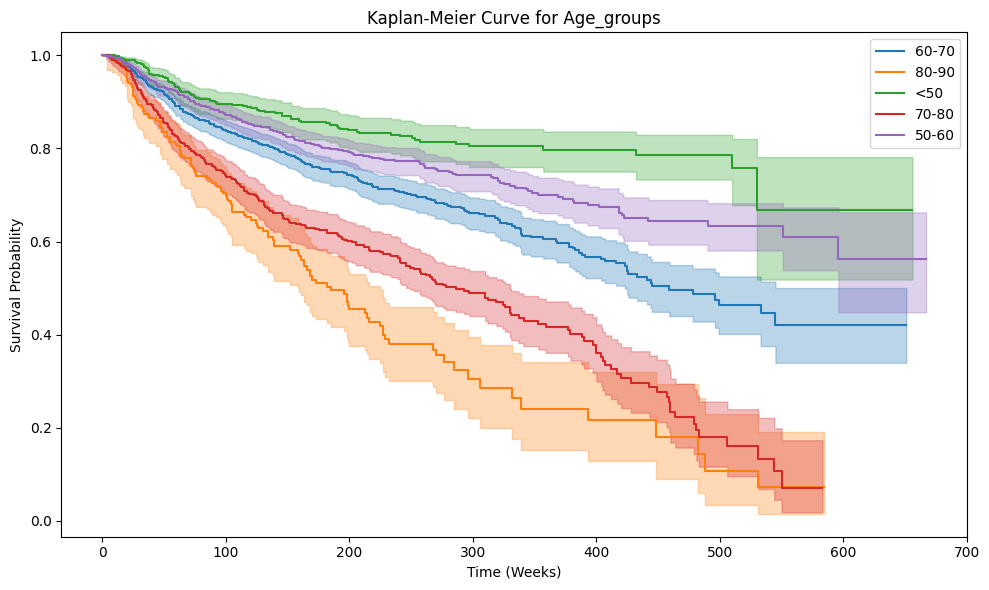

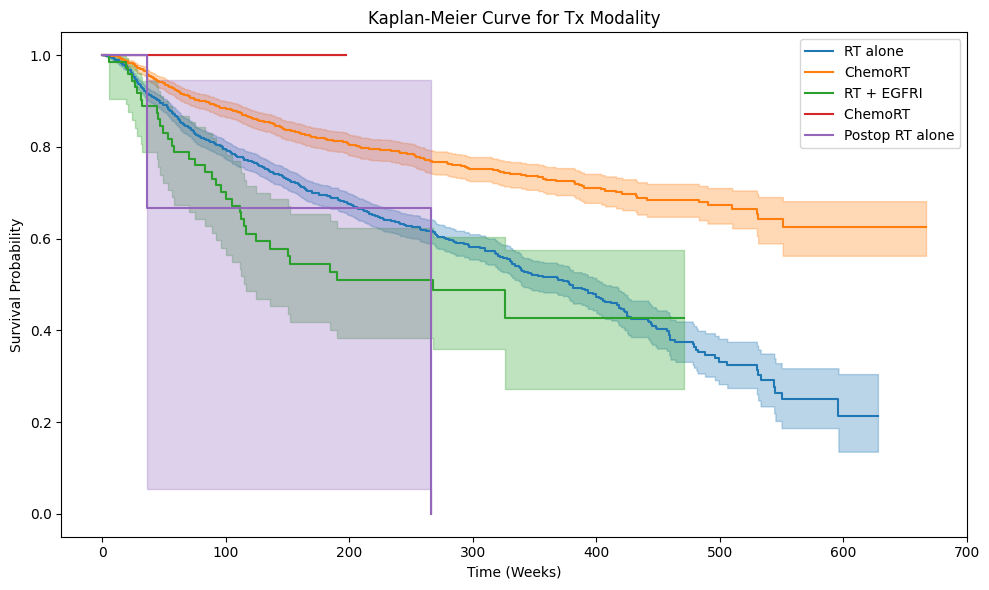

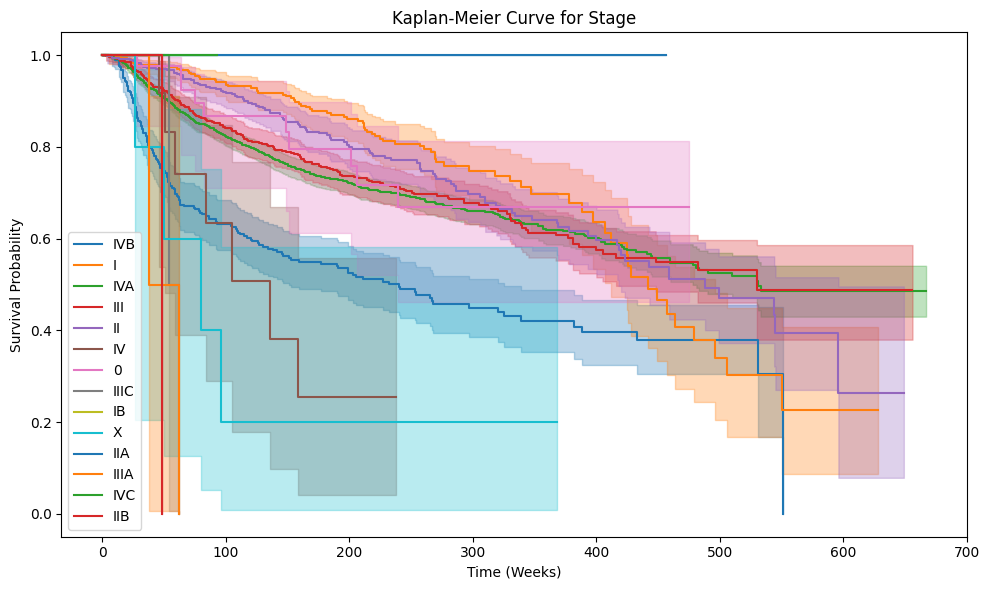

Log-rank test outcomes for group Age_groups
         patient_id   Age     Sex ECOG PS Smoking PY Smoking Status  \
0     RADCURE-0005  62.6  Female  ECOG 0         50      Ex-smoker   
6     RADCURE-0012  61.0    Male  ECOG 0          5        Current   
12    RADCURE-0019  68.7    Male  ECOG 0         40      Ex-smoker   
14    RADCURE-0021  69.3    Male  ECOG 0          0     Non-smoker   
15    RADCURE-0022  69.0  Female  ECOG 1         55        Current   
...            ...   ...     ...     ...        ...            ...   
3333  RADCURE-4116  63.3    Male  ECOG 0          0     Non-smoker   
3335  RADCURE-4120  69.4    Male  ECOG 0          0     Non-smoker   
3337  RADCURE-4122  60.5    Male  ECOG 0         80        Current   
3338  RADCURE-4123  60.4    Male  ECOG 0         30      Ex-smoker   
3339  RADCURE-4124  68.3    Male  ECOG 1          0     Non-smoker   

          Ds Site          Subsite    T    N  ...    Last FU Status  \
0      Oropharynx        post wall  T4b  N2

In [35]:
# 3.1. Kaplan-Meier (KM) Analysis: 

# Renaming the clinical dataset: 

KM_data = rad_clin_data.copy()  

# To implement the Status and Survival times of the patients in the clinical dataset (for the KM Analysis): 

KM_data['observed_status'] = KM_data['Status'].map({'Alive': 0, 'Dead': 1})

KM_data['surv_time'] = (KM_data['Date of Death'].where(KM_data['observed_status'] == 1, KM_data['Last FU'])
                                      - KM_data['RT Start']).dt.days //7                                    # Days were converted to weeks for better data visualization. 

# Creating the age group for the KM Plot:

KM_data['Age_groups'] = pd.cut(KM_data['Age'],                                                  # Bins were categorized. In this case, most of the patients were between 50-100. 
                               bins = [0, 50, 60, 70, 80, 90, 100],                             # Hence, they were emphasized more. 
                               labels = ['<50', '50-60', '60-70', '70-80', '80-90', '90-100'])

# Creating a loop for the KM plot generation (for all 3 groups): 

groups = ['Age_groups', 'Tx Modality', 'Stage']

for group_col in groups:
    plt.figure(figsize=(10, 6))
    kmf = KaplanMeierFitter()
    
    for group_val in KM_data[group_col].dropna().unique():  # This makes sure that there are no NA values (if so, they are dropped) and that the distinct groups are determined. 
        either_group = KM_data[group_col] == group_val
        kmf.fit(
            durations = KM_data[either_group]['surv_time'], 
            event_observed = KM_data[either_group]['observed_status'],
            label = str(group_val)
        )
        kmf.plot_survival_function(ci_alpha = 0.3)

    # Plotting the Kaplan-Meier curves using Matplotlib: 
    plt.title(f'Kaplan-Meier Curve for {group_col}')
    plt.xlabel('Time (Weeks)')
    plt.ylabel('Survival Probability')
    plt.tight_layout()
    plt.show()

# Performing the log-rank tests for the group combinations (looped): 

def conduct_logrank_test(KM_data, group):                                # In this log-rank test, p-values for subgroups in each group were determined. 
    groups = KM_data[group].dropna().unique()                            # Hence, there are numerous p-values (in the output). 
    print(f"Log-rank test outcomes for group {group}")
    for g1, g2 in itertools.combinations(groups, 2):
        one = KM_data[KM_data[group] == g1]
        two = KM_data[KM_data[group] == g2]
        results = logrank_test(one['surv_time'], two['surv_time'], 
                               event_observed_A=one['observed_status'],
                               event_observed_B=two['observed_status']
                            )
        print(f" {one} compared to {two}: p-value = {results.p_value:.4f}")
for group in groups: 
    conduct_logrank_test(KM_data, group)      

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


Note: you may need to restart the kernel to use updated packages.


<lifelines.CoxPHFitter: fitted with 3318 total observations, 2268 right-censored observations>
             duration col = 'surv_time'
                event col = 'observed_status'
      baseline estimation = breslow
   number of observations = 3318
number of events observed = 1050
   partial log-likelihood = -7657.50
         time fit was run = 2025-07-14 23:16:08 UTC

---
                              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                     
Age                           0.04      1.04      0.00            0.03            0.04                1.03                1.04
Tx Modality_ChemoRT         -12.13      0.00    994.49        -1961.30         1937.04                0.00                 inf
Tx Modality_Postop RT alone   2.06      7.85      0.71            0.66            3.46                1.94               31.72
Tx Modality_RT + EGFRI        0.53      1.69      0.18            0.17            0.89                1.18                2.42
Tx Modality_RT alone          0.77      2.16      0.08            0.61            0.93                1.85                2.53
Stage_I                      -0.22      0.80      0.34           -0.88            0.43                0.41                1.54
Stage_IB                    -17.25      0.00  29451.47       -57741.08        57706.58                0.00                 inf
Stage_II                      0.06      1.06      0.33           -0.59            0.70                0.55                2.02
Stage_IIA                   -11.19      0.00    590.00        -1167.56         1145.19                0.00                 inf
Stage_IIB                     2.20      8.99      1.05            0.14            4.26                1.15               70.49
Stage_III                     0.44      1.56      0.33           -0.20            1.08                0.82                2.94
Stage_IIIA                    2.75     15.63      0.78            1.22            4.27                3.40               71.74
Stage_IIIC                    2.67     14.42      0.78            1.15            4.19                3.15               65.93
Stage_IV                      1.43      4.18      0.49            0.46            2.40                1.59               11.01
Stage_IVA                     0.77      2.15      0.32            0.14            1.39                1.15                4.03
Stage_IVB                     1.57      4.79      0.33            0.92            2.21                2.52                9.12
Stage_IVC                   -12.73      0.00   1477.74        -2909.04         2883.58                0.00                 inf
Stage_X                       1.88      6.56      0.59            0.72            3.04                2.05               20.93

                             cmp to     z      p  -log2(p)
covariate                                                 
Age                            0.00 11.39 <0.005     97.40
Tx Modality_ChemoRT            0.00 -0.01   0.99      0.01
Tx Modality_Postop RT alone    0.00  2.89 <0.005      8.03
Tx Modality_RT + EGFRI         0.00  2.88 <0.005      7.96
Tx Modality_RT alone           0.00  9.58 <0.005     69.79
Stage_I                        0.00 -0.67   0.51      0.98
Stage_IB                       0.00 -0.00   1.00      0.00
Stage_II                       0.00  0.17   0.86      0.21
Stage_IIA                      0.00 -0.02   0.98      0.02
Stage_IIB                      0.00  2.09   0.04      4.77
Stage_III                      0.00  1.36   0.17      2.52
Stage_IIIA                     0.00  3.54 <0.005     11.26
Stage_IIIC                     0.00  3.44 <0.005     10.75
Stage_IV                       0.00  2.89 <0.005      8.03
Stage_IVA                      0.00  2.38   0.02      5.87
Stage_IVB                      0.00  4.77 <0.005     19.06
Stage_IVC           

c:\Users\Zahin\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\coxph_fitter.py:2636: RuntimeWarning: overflow encountered in exp
  upper_errors = exp_log_hazards * (exp(z * self.standard_errors_[columns].values) - 1)


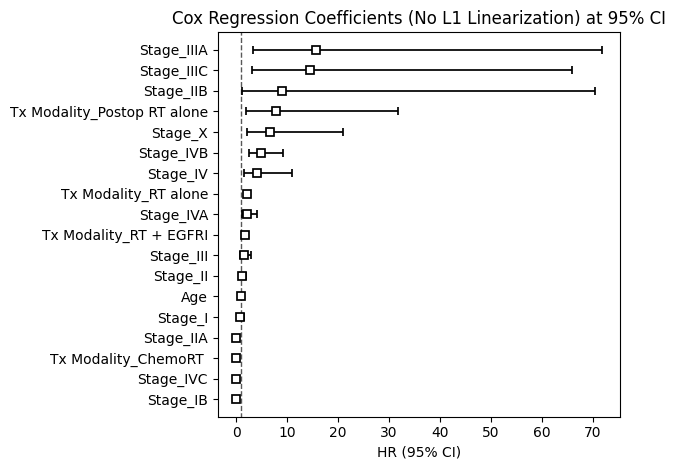

Concordance Index for the L1-Regularized Cox Regression Model: 0.6360


In [ ]:
# 3.2. Cox Proportional Hazards Regression: 

%pip install jinja2                                                                               # I was getting an error for not installing jinja2; hence, I installed it. 

# Renaming the clinical dataset: 

cox_regr_data = rad_clin_data.copy()  

# The categorical variables were converted using pd.dummies for the cox regression analysis: 

cox_regr_data = pd.get_dummies(cox_regr_data, columns=['Tx Modality', 'Stage'], drop_first=True)   # I was getting an error; hence, I used drop_first to avoid multicollinearity. 

# The following was performed to narrow down my covariate list from the actual dataset (numerical = age; others are categorical dummies): 

cox_covariates = ['Age'] + [col for col in cox_regr_data.columns if (col.startswith('Tx Modality') or col.startswith('Stage')) and col not in ['Tx Modality', 'Stage']]

# To implement the Status and Survival times of the patients in the clinical dataset (for the Cox regression): 

cox_regr_data['observed_status'] = cox_regr_data['Status'].map({'Alive': 0, 'Dead': 1})

cox_regr_data['surv_time'] = (cox_regr_data['Date of Death'].where(cox_regr_data['observed_status'] == 1, cox_regr_data['Last FU'])
                                      - cox_regr_data['RT Start']).dt.days //7                                                      # Again, I converted the days to weeks. 

# Adding the new variables to the cox_covariates set: 

cox_dataset = cox_regr_data[cox_covariates + ['observed_status', 'surv_time']]

# Fitting the variables into the Cox model: 

cph = CoxPHFitter()
cph.fit(cox_dataset, duration_col='surv_time', event_col='observed_status')

# Summary of the model: 

cph.print_summary()

# Plotting the model using Matplotlib: 

cph.plot(hazard_ratios = True)                                            # In Cox regression, we are interested to know the hazard ratios; hence, I added hazard_ratio = TRUE. 
plt.title("Cox Regression Coefficients (No L1 Linearization) at 95% CI")
plt.tight_layout()
plt.show()

# Preparing the Cox dataset for sksurv:

X = cox_dataset.drop(columns=['surv_time', 'observed_status']).astype(float)

y = np.array([(bool(event), time) for event, time in zip(cox_dataset['observed_status'], cox_dataset['surv_time'])], dtype=[('event', bool), ('time', float)])

# Splitting the Cox dataset into training and testing sets: 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=150)

# Fitting the Cox proportional hazards model with L1 regularization (for reducing data sparcity (i.e. missing values) and properly handling multicollinearity issues):  

cph_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0)
cph_lasso.fit(X_train, y_train)

# Predicting the risk scores (used for calculating the concordance index): 

risk_scores = cph_lasso.predict(X_test)
 
# Calculating the concordance index: 

c_index_Cox = concordance_index_censored(y_test['event'], y_test['time'], risk_scores)[0]
print(f'Concordance Index for the L1-Regularized Cox Regression Model: {c_index_Cox:.4f}')


Concordance Index for the RSF: 0.6360


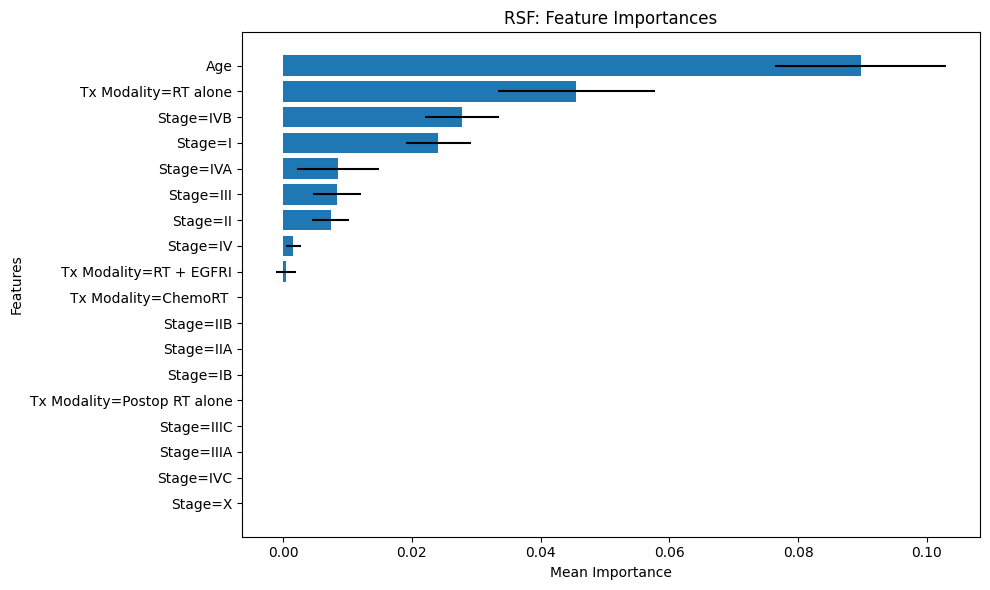

In [37]:
# 3.3. Random Survival Forests (RSF): 

# Renaming the RSF dataset: 

RSF_data = rad_clin_data.copy()  

# To implement the Status and Survival times of the patients in the clinical dataset (for the RSF model): 

RSF_data['observed_status'] = RSF_data['Status'].map({'Alive': 0, 'Dead': 1})

RSF_data['surv_time'] = (RSF_data['Date of Death'].where(RSF_data['observed_status'] == 1, RSF_data['Last FU'])
                                      - RSF_data['RT Start']).dt.days //7                                         # Again, days were converted to weeks. 

# Encoding the categorical variables: 

numerical_col = ['Age']
categorical_col = ['Tx Modality', 'Stage']
X_vars = numerical_col + categorical_col

# Ensuring that the categorical columns are of the 'category' type:  
for col in categorical_col:
    RSF_data[col] = RSF_data[col].astype('category')

encoder = OneHotEncoder()                                     # OneHotEncoder was used to convert the aforementioned categorical variables to binary (0 and 1) values. 
RSF_X = encoder.fit_transform(RSF_data[X_vars])
RSF_y = np.array([(bool(event), time) for event, time in zip(RSF_data['observed_status'], RSF_data['surv_time'])], dtype=[('event', bool), ('time', float)])

# Splitting the RSF dataset into training and testing sets: 

X1_train, X1_test, y1_train, y1_test = train_test_split(RSF_X, RSF_y, test_size=0.2, random_state=150)

# Fitting and predicting the Random Survival Forests model: 

rsf_1 = RandomSurvivalForest(n_estimators = 100, random_state = 150)
rsf_1.fit(X1_train, y1_train)
RSF_risk_scores = rsf_1.predict(X1_test)

# # Calculating the concordance index for RSF: 

c_index_RSF = concordance_index_censored(y1_test['event'], y1_test['time'], risk_scores)[0]
print(f'Concordance Index for the RSF: {c_index_RSF:.4f}')

# Conductiong the permutation importance and feature importance: 

result = permutation_importance(rsf_1, X1_test, y1_test, n_repeats=15, random_state=150)      # Permutation importance - it is used to see which features in your dataset
                                                                                              # are significant in predicting your RSF model's outcomes. 
# Get feature names from the encoder
try:
    feature_names = encoder.get_feature_names_out(numerical_col + categorical_col)            # try/except: to make sure that no errors prevent the codes from running. 
except AttributeError:
    feature_names = encoder.get_feature_names(numerical_col + categorical_col)

feature_importance = pd.DataFrame(                                                            # Feature Importance - it is used to see which features are significant for our RSF
         {                                                                                    # model's outcomes. 
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=feature_names,
).sort_values(by="importances_mean", ascending=False)

# Sorting by importances_mean (preparing the data for better visualization): 

feature_importance = feature_importance.sort_values(by="importances_mean", ascending=False)

# Plotting the model using Matplotlib: 

plt.figure(figsize=(10, 6))
plt.title('RSF: Feature Importances')
plt.barh(feature_importance.index, feature_importance['importances_mean'], xerr=feature_importance['importances_std'], align='center')
plt.xlabel('Mean Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Based on the comparison between the concordance indices from RSF and Cox regression, both of them generated the same index of 0.6360. 
# Hence, they both showed very similar predictive outcomes. 